## Import Packages and Data

In [1]:
# AYU CODE
import pickle
import random
from scipy import fft
from qtn.bimax import BiMax
from qtn.util import (boltzmann, emass, echarge, permittivity, cspeed, fperp, fp)
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
from pyspedas import wind
from pytplot import tplot, get_data
import pandas as pd
import time
import netCDF4 as nc
from functions import Timer
%matplotlib inline

In [2]:
random.random()

0.7274108574444563

In [3]:
def find_closest_time(time, lst):
    """
    A function used to find the index of the closest time in a list 
    to the specific time held in the variable time
    """
    return min(range(len(lst)), key=lambda i: abs(time-lst[i]))

def helper(wrel, lrel, n, t, tc):
    # add precision control to bimax function for enoise
    mp.mp.dps = 3 if reduce_precison else (40 if wrel > 1 and wrel < 1.2 else 20) 
    return p.bimax(wrel, lrel, n, t, tc)

# Functions to make code cleaner
def gs_func(wrelplot, lrel, n, t, tc):
    return np.array([p.gamma_shot(wrel, lrel, n, t, tc) for wrel in wrelplot])

def enoise_func(wrelplot, lrel, n, t, tc): 
    return np.array([helper(wrel, lrel, n, t, tc) for wrel in wrelplot])

def pnoise_func(wrelplot, lrel, tep, tc, vsw):
    return np.array([p.proton2(wrel*np.sqrt(1+n), lrel, tep, tc, vsw) for wrel in wrelplot])

gs_seperate = lambda gs: [gs[:,0], gs[:,1]]

def calc_params(tc, ne, t, n): 
    fpe = (80.64828175895765*ne)**.5
    nc = ne/(1+n)               
    ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2) 
    lrel = ant_len/ldc       
    wrelplot = fbins/fpe
    
    return wrelplot, fpe, nc, lrel

def calc_t(te,tc,n):
    t = n/((1+n)/(te/tc) - 1)
    return t

In [4]:
T = Timer.Timer()
T.start()

### Imported Parameters
* vsw: Solar Wind Speed                  - Solar Wind Experiment(SWE)
* tc: core electron temperature ~ electron temperature - statistical paper 
* fpe: core electron plasma frequency    - Use WIND/WAVES NN
* t: halo/core electron temperature ratio - 
* n: halo/core electron density ratio     - 
* tep: electron to proton temperature ratio - statistical paper 

### Calculated Parameters
* ne: electron density
* nc: core electron density       
* ldc: core debye length                 
* lrel: relative length of antenna

#### Fixed Parameters: Antenna Geometry

In [5]:
# Antenna Geometry
reduce_precison = True
ant_len = 50      # m (monopole) 
ant_rad = 1.9e-4  # m
base_cap = 20e-12 # Farad
fbins = np.array([4000*1.0445**i for i in range(96)])

#### Changing Parameters: Plasma Parameters

In [6]:
# Solar Wind Parameters
vsw=3.966e5                   # Solar Wind Speed
tc = 9.91 * echarge/boltzmann # Core electron temperature
t = 6.57                      # ??? Only used to calculate electron noise and shot noise
n = 0.026                     # ??? Some sort of ratio between core electron and normal electron density
tep = 9.91/9.62               # Electron Temperature/Proton Temperature Ratio
fpe = 31.47e3                 # Electron Plasma Frequency

ne = 12.28e6 # Electron Density
nc = ne/(1+n)                 # ??? Core Electron Density
ldc = np.sqrt(permittivity * boltzmann * tc/ nc / echarge**2) # Debye Length
lrel = ant_len/ldc            # Relative length antenna to debye length

wrelplot = fbins/fpe

In [7]:
fpe**2/ne

80.64828175895765

In [8]:
# Solar Wind Parameter Ranges
vsw_ranges_km = [[250,300], [300,350], [350,400], [400,450], 
                [450,500], [500,550], [550,600], [600,650], 
                [650,700], [700,750], [750,800]]

ne_ranges_log= [[1.10, 0.15], [1.05, 0.19], [0.96, 0.18],
                [0.87, 0.18], [0.81, 0.19], [0.73, 0.19],
                [0.67, 0.17], [0.66, 0.18], [0.62, 0.13],
                [0.56, 0.11], [0.57, 0.08]]

tep_ranges_log = [[0.72, 0.15], [0.64, 0.23], [0.42, 0.23],
                 [0.27, 0.22], [0.11, 0.21], [0.00, 0.19],
                 [-0.09, 0.19], [-0.23, 0.16], [-0.32, 0.12],
                 [-0.37, 0.12], [-0.44, 0.08]]

tc_ranges = [[8.84, 1.06], [10.02, 1.89], [10.07, 1.96],
            [10.32, 1.89], [10.25, 1.75], [9.82, 1.74],
            [9.64, 1.57], [8.39, 1.25], [7.12, 0.87],
            [7.01, 0.84], [6.95, 0.91]]

nh_nc_ranges_log = [[-1.82, 0.25], [-1.62, 0.28], [-1.51, 0.29],
                   [-1.38, 0.24], [-1.34, 0.23], [-1.25, 0.21],
                   [-1.20, 0.21], [-1.22, 0.23], [-1.21, 0.23],
                   [-1.21, 0.22], [-1.16, 0.19]]

th_tc_ranges_log = [[5.90, 0.92], [5.23, 0.97], [5.20, 0.94],
                   [5.11, 0.93], [5.12, 0.83], [5.05, 0.99],
                   [5.04, 1.00], [5.04, 1.03], [4.82, 1.01],
                   [4.77, 1.08], [4.53, 0.92]]

In [9]:
vsw_ranges       = np.array(vsw_ranges_km)*10**3
ne_ranges_log    = np.array(ne_ranges_log)
nh_nc_ranges_log = np.array(nh_nc_ranges_log)
tep_ranges_log   = np.array(tep_ranges_log)
tc_ranges        = np.array(tc_ranges)* echarge/boltzmann
th_tc_ranges_log = np.array(th_tc_ranges_log)

In [87]:
# Error propogation for log error
# error = (partial 10^x / partial x) * log_error
# error = ln(10)*10^x * log_error
base10 = lambda x: 10**x
base10error = lambda x, e: np.log(10)*(10**x)*e
base10list = lambda lst: np.array([[base10(x), base10error(x,e)] for x, e in lst])

ne_ranges    = base10list(ne_ranges_log)*1e6
nh_nc_ranges = base10list(nh_nc_ranges_log)
tep_ranges   = base10list(tep_ranges_log)
th_tc_ranges = (th_tc_ranges_log)
print(vsw_ranges[0], ne_ranges[0], nh_nc_ranges[0], tep_ranges[3], tc_ranges[0], th_tc_ranges[0])

[250000 300000] [12589254.11794167  4348174.32958296] [0.01513561 0.00871276] [1.86208714 0.9432751 ] [102583.95095697  12300.79049937] [5.9  0.92]


In [88]:
compute_midpoints = lambda lst: [lst[0]-(lst[1]-lst[0])/2]+[(lst[i+1]+lst[i])/2 for i in range(len(lst)-1)]+[lst[-1]+(lst[-1]-lst[-2])/2]
linear_scale = lambda x, x_low, x_high, y_low, y_high: (x-x_low)/(x_high-x_low)*(y_high-y_low)+y_low 

ne_mid    = compute_midpoints(ne_ranges[:, 0])
tep_mid   = compute_midpoints(tep_ranges[:, 0])
tc_mid    = compute_midpoints(tc_ranges[:, 0])
nh_nc_mid = compute_midpoints(nh_nc_ranges[:, 0])
th_tc_mid = compute_midpoints(th_tc_ranges[:, 0])

In [93]:
np.random.seed(1000)

def gen_random_data():
    index = np.random.randint(0, len(vsw_ranges))
    # vsw, ne, tep, tc, n, t
    sd_scale = 0
    vsw_val, low, high = np.random.uniform(vsw_ranges[index,0], vsw_ranges[index,1]),vsw_ranges[index,0], vsw_ranges[index,1]
    ne_val    = linear_scale(vsw_val, low, high, ne_mid[index],ne_mid[index+1])
    tep_val   = linear_scale(vsw_val, low, high, tep_mid[index],tep_mid[index+1])
    tc_val    = linear_scale(vsw_val, low, high, tc_mid[index],tc_mid[index+1])
    nh_nc_val = linear_scale(vsw_val, low, high, nh_nc_mid[index],nh_nc_mid[index+1])
    th_tc_val = linear_scale(vsw_val, low, high, th_tc_mid[index],th_tc_mid[index+1])
    
    return [vsw_val,
            np.random.normal(ne_val,    ne_ranges[index, 1]*sd_scale),
            np.random.normal(tep_val,   tep_ranges[index, 1]*sd_scale),
            np.random.normal(tc_val,    tc_ranges[index, 1]*sd_scale),
            np.random.normal(nh_nc_val, nh_nc_ranges[index, 1]*sd_scale),
            np.random.normal(th_tc_val, th_tc_ranges[index, 1]*sd_scale)]

data = np.array([gen_random_data() for _ in range(200)])

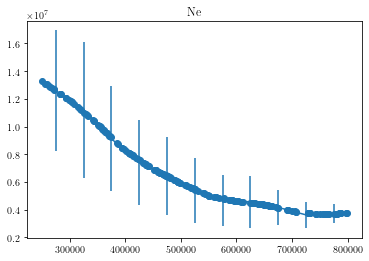

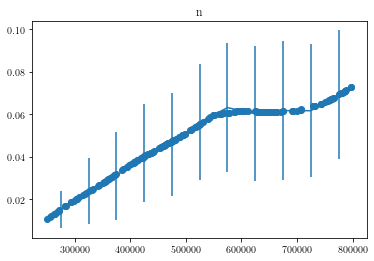

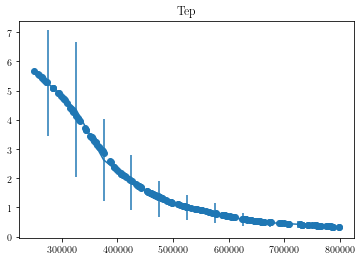

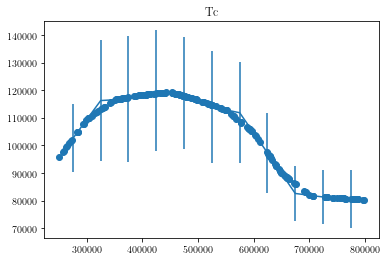

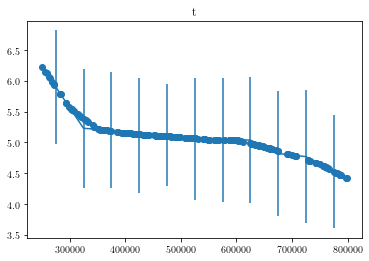

In [94]:
plt.title("Ne")
plt.scatter(data[:,0], data[:,1])
plt.errorbar(vsw_ranges[:,1]-25000,  ne_ranges[:,0], yerr=ne_ranges[:,1])
plt.show()
plt.title("n")
plt.scatter(data[:,0], data[:,4])
plt.errorbar(vsw_ranges[:,1]-25000,  nh_nc_ranges[:,0], yerr=nh_nc_ranges[:,1])
plt.show()
plt.title("Tep")
plt.scatter(data[:,0], data[:,2])
plt.errorbar(vsw_ranges[:,1]-25000,  tep_ranges[:,0], yerr=tep_ranges[:,1])
plt.show()
plt.title("Tc")
plt.scatter(data[:,0], data[:,3])
plt.errorbar(vsw_ranges[:,1]-25000,  tc_ranges[:,0], yerr=tc_ranges[:,1])
plt.show()
plt.title("t")
plt.scatter(data[:,0], data[:,5])
plt.errorbar(vsw_ranges[:,1]-25000,  th_tc_ranges[:,0], yerr=th_tc_ranges[:,1])
plt.show()

In [95]:
gamma_time = 10.2781822681
enoise_time = 6.1188266277
pnoise_time = 0.2680702209
total_time = gamma_time+enoise_time+pnoise_time

print("Estimate time:", total_time*len(data))
print("Size:", len(data))

Estimate time: 3333.0158233399998
Size: 200


In [96]:
p = BiMax(ant_len, ant_rad, base_cap,True)

In [97]:
T = Timer.Timer()
T.start()
spectra = []
data_params = []
count = 0
for vsw, ne, tep, tc, n, t in data:
    if count%5==0:
        T.lap(count)
        print(T.last_lap())
        
    wrelplot, fpe, nc, lrel = calc_params(tc, ne, t, n)
    gamma, shot = gs_seperate(gs_func(wrelplot, lrel, n, t, tc))
    enoise = enoise_func(wrelplot, lrel, n, t, tc)
    pnoise = pnoise_func(wrelplot, lrel, tep, tc, vsw)
    vr2 = (enoise + pnoise + shot)/gamma
        
    spectra.append(vr2)
    data_params.append([vsw, ne, tep, tc, n, t, fpe, nc])
    count += 1

T.stop()
print(T.summary())

0: 0.0001809597

5: 87.5802373886

10: 91.5833513737

15: 90.7883856297

20: 95.365459919

25: 98.7576396465

30: 92.8290843964

35: 95.2813928127

40: 97.3661131859

45: 95.8220000267

50: 97.3676617146

55: 94.6747131348

60: 92.4773175716

65: 93.6030380726

70: 98.3597512245

75: 96.3523817062

80: 121.9448878765

85: 105.3042809963

90: 100.9838964939

95: 96.7154750824

100: 97.6887764931

105: 96.1594212055

110: 98.8937785625

115: 101.5650618076



KeyboardInterrupt: 

In [ ]:
spectra_num = [[float((num)) for num in row] for row in spectra]

In [ ]:
#vsw, ne, tep, tc, n, t, fpe, nc
params = list(zip(*data_params))
with open("data/synthetic_data_revised_v3",'wb') as file:
    pickle.dump({"spectra":spectra_num,
                "parameters":{"vsw" :np.array(params[0]),#.repeat(1000, axis=0), 
                              "ne":np.array(params[1])/1e6,#.repeat(1000, axis=0), 
                              "tep" :np.array(params[2]),#.repeat(1000, axis=0), 
                              "tc" :np.array(params[3]),#.repeat(1000, axis=0), 
                              "n" :np.array(params[4]),#.repeat(1000, axis=0), 
                              "t" :np.array(params[5]),#.repeat(1000, axis=0), 
                              "fpe" :np.array(params[6])/1e3,#.repeat(1000, axis=0), 
                              "nc":np.array(params[7])}},#.repeat(1000, axis=0)}}, 
                file)

In [59]:
np.shape(spectra_num)

(200, 96)

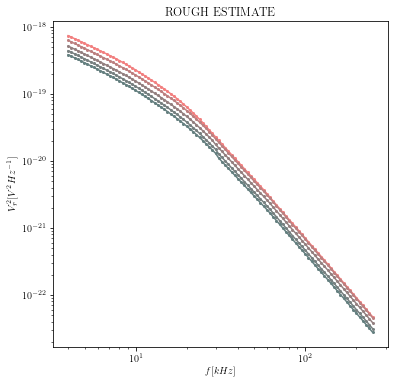

In [80]:
#T.lap("Plot")
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig = plt.figure(figsize=[6, 6], facecolor='w')
for i in range(len(spectra)):
    plt.plot(fbins/1000, spectra[i], 'o-', markersize=2, label=f"fpe = {i}", color=(params[1][i]/1.4e7, .5, .5))
# plt.plot(fbins/1000, spectra[0], 'o-', markersize=2, label='fpe = 30e3')
# plt.plot(fbins/1000, spectra[1], 'o-', markersize=2, label='fpe = 31e3')
# plt.plot(fbins/1000, spectra[2], 'o-', markersize=2, label='fpe = 32e3')
# plt.plot(fbins/1000, spectra[4], 'o-', markersize=2, label='total')
# plt.plot(fbins/1000, spectra[5], 'o-', markersize=2, label='total')
# plt.plot(fbins/1000, spectra[6], 'o-', markersize=2, label='total')
# plt.plot(fbins/1000, spectra[7], 'o-', markersize=2, label='total')
#plt.plot(fbins/1000, enoise/gamma, label='electron')
#plt.plot(fbins/1000, pnoise/gamma, label='proton')
#plt.plot(fbins/1000, shot/gamma, label='shot')
plt.xscale('log')
plt.yscale('log')
#plt.xlim([4, 256])
#plt.ylim([1e-16, 5e-13])
plt.xlabel(r'$f[kHz]$')
plt.ylabel(r'$V_r^2[V^2Hz^{-1}]$')
plt.title('ROUGH ESTIMATE')
#plt.legend(loc='best')
plt.savefig("plots/synthetic_params/fpe_v2.png", dpi=150)
plt.show()

In [20]:
raise error
fig.savefig('plots/wind19950625_theoretical.png', dpi=300)

NameError: name 'error' is not defined

In [22]:
pd.DataFrame(np.array(params[6])).describe()

,0
count,1000.000000
mean,22441.351734
std,4940.781916
min,15666.096075
25%,18274.023609
50%,20921.645447
75%,26077.058912
max,35094.489501
